# Rating Distribution Analysis for Banana Republic (on Amazon)

In [1]:
#importing required packages
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import random
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#intializing the options object to be fed into webdriver parameters
chrome_options=Options()
#chrome_options.add_argument("--headless")
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [3]:
# Add a custom User-Agent
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
chrome_options.add_argument(f'user-agent={user_agent}')

In [4]:
'''
Adding the property to not let program close the browser window post execution
This comes quite handy while visualizing how browser content are changing during 
execution and what was the last state of browser
'''
chrome_options.add_experimental_option("detach", True)

In [5]:
#starting the chrome driver
driver=webdriver.Chrome(options=chrome_options)

In [6]:
#setting up the target website ot be scrapped
target='https://www.amazon.com/s?k=banana+republic+clothing&page=2&crid=5GXNBG6XBWK7&qid=1727765297&sprefix=banana+republic+clothing%2Caps%2C218&ref=sr_pg_2'

In [7]:
#getting the web page
driver.get(target)
#waiting for the page to load
time.sleep(random.uniform(2, 10))
#maximizing the browser window
driver.maximize_window()

In [8]:
# Store product data
product_data = {
    "Product Name": [],
    "Price": [],
    "Rating": [],
    "Review Count": []
}

In [9]:
page_number=1
while page_number<7:
    #selecting a product block
    products = driver.find_elements(By.XPATH, '//div[contains(@class, "s-main-slot")]/div[@data-component-type="s-search-result"]')

    # Iterate over the products and extract details
    for product in products:
        product_name = product.find_element(By.XPATH, './/h2[@class="a-size-mini s-line-clamp-1"]').text
        if 'Banana Republic Factory' in product_name or 'Banana Republic' in product_name:
            try:
                # Product Name
                product_name = product.find_element(By.XPATH,'.//span[@class="a-size-base-plus a-color-base a-text-normal"]').text
            except:
                product_name = 'N/A'

            try:
                # Price
                price = product.find_element(By.XPATH, './/span[@class="a-price-whole"]').text
                price_fraction = product.find_element(By.XPATH, './/span[@class="a-price-fraction"]').text
                full_price = f"{price}.{price_fraction}"
            except:
                full_price = 'N/A'

            try:
                # Rating
                rating = product.find_element(By.XPATH, './/span[@class="a-icon-alt"]').get_attribute('innerHTML').split()[0]
            except:
                rating = 'N/A'

            try:
                # Review Count
                review_count = product.find_element(By.XPATH, './/span[@class="a-size-base s-underline-text"]').text
            except:
                review_count = 'N/A'

            # Store the product details in the dictionary
            product_data["Product Name"].append(product_name)
            product_data["Price"].append(full_price)
            product_data["Rating"].append(rating)
            product_data["Review Count"].append(review_count)
        else:
            pass
    
    try:
        #incrementing the page number
        page_number+=1
        #wait till the next button appears and then locate it
        button = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, '//a[contains(@class, "s-pagination-next")]'))
        )
        # Click the "Next" button
        button.click()
        
        #waiting for the page to load
        time.sleep(10)
    except:
        print(page_number)
        print("No 'Next' button found. Ending the loop.")
        break


7
No 'Next' button found. Ending the loop.


In [30]:
df = pd.DataFrame(product_data)

In [31]:
df.shape

(38, 4)

In [34]:
df['Rating'].value_counts()

N/A    29
5.0     7
4.0     1
3.0     1
Name: Rating, dtype: int64

In [35]:
df['Review Count'].value_counts()

N/A    29
1       5
2       3
3       1
Name: Review Count, dtype: int64

In [36]:
# Replace 'N/A' strings with NaN
df['Rating'].replace('N/A', np.nan, inplace=True)
df['Review Count'].replace('N/A', np.nan, inplace=True)

# Convert 'Rating' and 'Review Count' columns to numeric, forcing non-numeric values to NaN
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Review Count'] = pd.to_numeric(df['Review Count'], errors='coerce')

# Fill missing values in the 'Rating' column with the average (mean) of the ratings
df['Rating'].fillna(df['Rating'].mean(), inplace=True)

# Fill missing values in the 'Review Count' column with the median of the review counts
df['Review Count'].fillna(df['Review Count'].median(), inplace=True)

In [37]:
df['Rating'].value_counts()

4.666667    29
5.000000     7
4.000000     1
3.000000     1
Name: Rating, dtype: int64

In [38]:
df['Review Count'].value_counts()

1.0    34
2.0     3
3.0     1
Name: Review Count, dtype: int64

In [39]:
df.dtypes

Product Name     object
Price            object
Rating          float64
Review Count    float64
dtype: object

In [40]:
df.head(100)

,Product Name,Price,Rating,Review Count
0,Banana Republic Mens 710638 Standard Fit Luxe ...,38.99,4.666667,1.0
1,Banana Republic Womens Slim Fit Mid Rise Ryan ...,69.95,5.000000,1.0
2,Banana Republic Mens Athletic Fit Wrinkle Resi...,69.95,4.666667,1.0
3,Banana Republic Womens 405131 V-Neck Soft Knit...,49.50,4.666667,1.0
4,Banana Republic 3-Pack Men's Knit Boxer Briefs...,62.99,4.666667,1.0
5,Banana Republic Men's 3-Pack Boxer Shorts X-La...,59.99,4.666667,1.0
6,Banana Republic Mens 710638 Standard Fit Luxe ...,44.99,4.666667,1.0
7,Banana Republic Mens Standard Fit Luxe Cotton ...,50.00,4.666667,1.0
8,Banana Republic Men's 3-Pack Boxer Shorts Mens...,59.99,4.000000,1.0
9,Banana Republic Mens Standard Fit Slub Knit Co...,45.00,4.666667,1.0


## Plot for Top 10 Most Popular Items based on Review Count

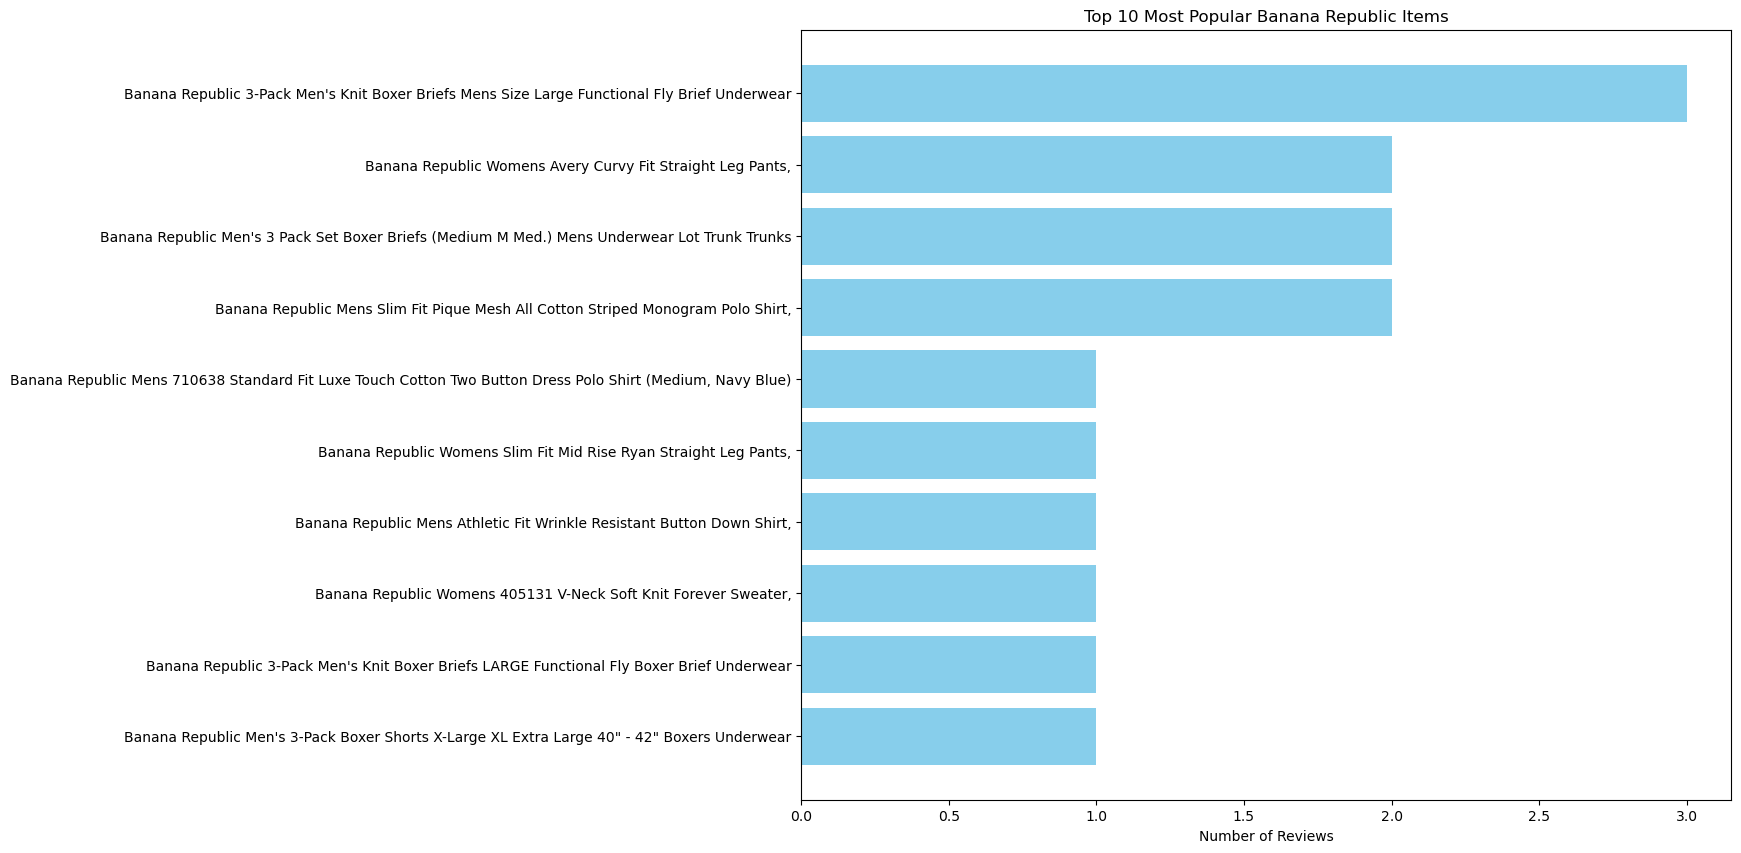

In [41]:
#visualization 1
#filtering by top review counts
top_popular_items = df.nlargest(10, 'Review Count')

plt.figure(figsize=(12, 10))
plt.barh(top_popular_items['Product Name'], top_popular_items['Review Count'], color='skyblue')
plt.xlabel('Number of Reviews')
plt.title('Top 10 Most Popular Banana Republic Items')
plt.gca().invert_yaxis()  # Invert y-axis to show the most popular items on top
plt.show()

##  Distribution of Ratings

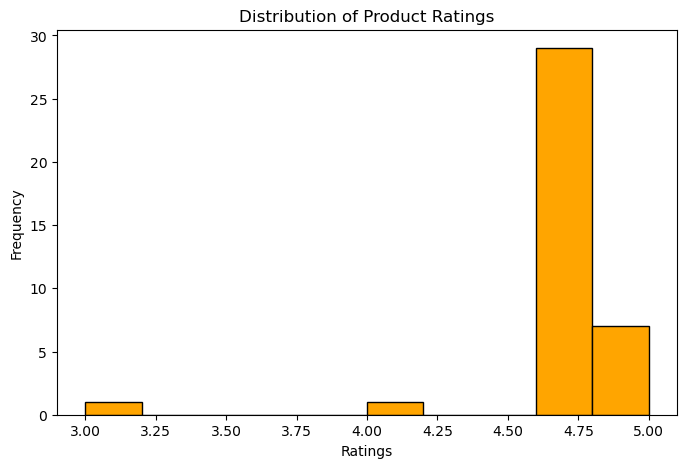

In [42]:
#visualization 2
plt.figure(figsize=(8, 5))
plt.hist(df['Rating'].dropna(), bins=10, color='orange', edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Product Ratings')
plt.show()

## Items with Lowest Ratings (Badly Reviewed)

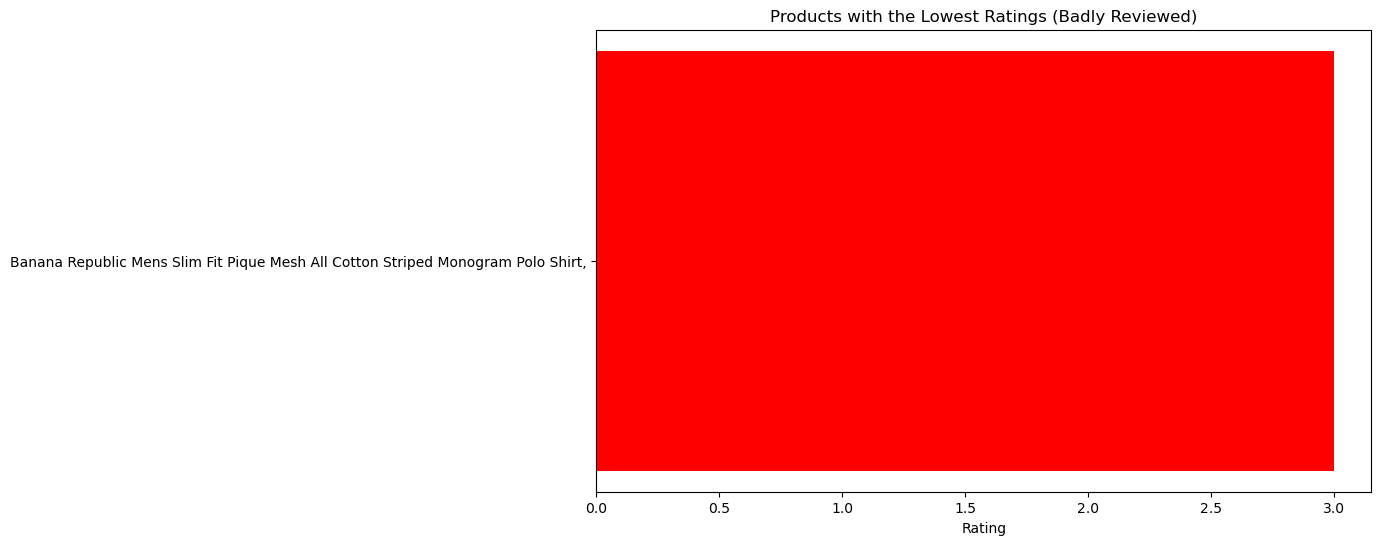

In [43]:
#visualization 3
# Assuming items with ratings below 4.0 are considered badly reviewed
badly_reviewed_items = df[df['Rating'] < 4.0]

plt.figure(figsize=(10, 6))
plt.barh(badly_reviewed_items['Product Name'], badly_reviewed_items['Rating'], color='red')
plt.xlabel('Rating')
plt.title('Products with the Lowest Ratings (Badly Reviewed)')
plt.gca().invert_yaxis()  # Invert y-axis to show the lowest ratings on top
plt.show()

## Elasticity Analysis (Review Count v/s Price, Ratings & Price v/s Ratings)

In [44]:
df.dtypes

Product Name     object
Price            object
Rating          float64
Review Count    float64
dtype: object

In [45]:
#changing the datatype of Price to float
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Data Cleaning - drop rows with missing values in relevant columns
df = df.dropna(subset=['Price', 'Review Count', 'Rating'])

#Log transformation for elasticity analysis
df['log_price'] = np.log(df['Price'])
df['log_review_count'] = np.log(df['Review Count'] + 1)  # Adding 1 to avoid log(0)
df['log_ratings'] = np.log(df['Rating'] + 1) # Adding 1 to avoid log(0)

In [46]:
df.head()

,Product Name,Price,Rating,Review Count,log_price,log_review_count,log_ratings
0,Banana Republic Mens 710638 Standard Fit Luxe ...,38.99,4.666667,1.0,3.663305,0.693147,1.734601
1,Banana Republic Womens Slim Fit Mid Rise Ryan ...,69.95,5.000000,1.0,4.247781,0.693147,1.791759
2,Banana Republic Mens Athletic Fit Wrinkle Resi...,69.95,4.666667,1.0,4.247781,0.693147,1.734601
3,Banana Republic Womens 405131 V-Neck Soft Knit...,49.50,4.666667,1.0,3.901973,0.693147,1.734601
4,Banana Republic 3-Pack Men's Knit Boxer Briefs...,62.99,4.666667,1.0,4.142976,0.693147,1.734601


In [47]:
#checking is any column is having NA values before feeding the data into a regression model
print(df[['log_review_count', 'log_ratings', 'log_price']].isna().sum())

log_review_count    0
log_ratings         0
log_price           0
dtype: int64


In [48]:
#Regression Model 1 - Review Count vs. Price and Ratings
X1 = df[['log_price', 'log_ratings']]
y1 = df['log_review_count']

# Add constant (intercept) to the model
X1 = sm.add_constant(X1)

# Fit the regression model
model1 = sm.OLS(y1, X1).fit()

# Print the summary of the regression model
print("Model 1: Review Count vs Price and Ratings")
print(model1.summary())

Model 1: Review Count vs Price and Ratings
                            OLS Regression Results                            
Dep. Variable:       log_review_count   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.8133
Date:                Tue, 01 Oct 2024   Prob (F-statistic):              0.452
Time:                        03:18:21   Log-Likelihood:                 17.634
No. Observations:                  37   AIC:                            -29.27
Df Residuals:                      34   BIC:                            -24.43
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const  

### Insights from the Regression Analysis for Elasticity

From the regression analysis output provided, we can derive insights into the elasticity of the `log_review_count` (dependent variable) with respect to the independent variables `log_price` and `log_ratings`. Elasticity in regression analysis, especially in a log-log model, represents the percentage change in the dependent variable for a 1% change in the independent variable.

### 1. **Understanding Coefficients:**
   - **`log_price` Coefficient:** The coefficient is 0.1545. In a log-log model, this implies that a 1% increase in the price (`log_price`) is associated with an approximate 0.1545% increase in the review count (`log_review_count`). However, given the p-value (0.336), this relationship is not statistically significant.
   - **`log_ratings` Coefficient:** The coefficient is -0.3898. This suggests that a 1% increase in the ratings (`log_ratings`) is associated with an approximate 0.3898% decrease in the review count (`log_review_count`). Similarly, the p-value (0.420) indicates that this relationship is also not statistically significant.

### 2. **Statistical Significance:**
   - Both `log_price` and `log_ratings` have high p-values (greater than 0.05), indicating that there is no statistically significant evidence to suggest that these variables affect the review count in this model.
   - The adjusted R-squared value is -0.010, which suggests that the model does not explain much of the variability in the review count. A negative adjusted R-squared value typically implies that the model is performing worse than a simple mean-based model.

### 3. **Elasticity Interpretation:**
   - **Price Elasticity:** Since the coefficient for `log_price` (0.1545) is positive, there is a small positive elasticity between price and review count. In economic terms, this might indicate that as the price increases, there is a slight increase in the number of reviews. However, this effect is not statistically significant, so this relationship is not reliable based on the data provided.
   - **Ratings Elasticity:** The coefficient for `log_ratings` (-0.3898) indicates a negative elasticity. This suggests that an increase in the product rating is associated with a decrease in the review count. However, the statistical insignificance (p-value = 0.420) means we cannot confidently conclude this relationship.

### 4. **Model Fit and Diagnostics:**
   - The R-squared value (0.046) and the adjusted R-squared value (-0.010) indicate that the model does not fit the data well. Only 4.6% of the variation in the `log_review_count` is explained by the independent variables (`log_price` and `log_ratings`).
   - The F-statistic's p-value (0.452) further confirms that the model as a whole is not statistically significant.

### 5. **Conclusion:**
   - **Elasticity Analysis:** The coefficients for both `log_price` and `log_ratings` suggest small elasticity effects, but the high p-values indicate that these effects are not statistically significant. Thus, there is no strong evidence from this regression analysis to suggest a reliable relationship between the review count and either price or ratings.
   - **Model Performance:** The model does not appear to capture the variability in the review count effectively. This could be due to omitted variables, non-linearity, or simply a weak relationship between the variables considered.

### Recommendations:
   - Consider collecting more data or including other variables that might have a more substantial impact on the review count.
   - Explore different model specifications, transformations, or non-linear models if the relationships between variables are not linear.

In [49]:
#Regression Model 2 - Price vs. Ratings only
X2 = df[['log_ratings']]
y2 = df['log_price']

# Add constant (intercept) to the model
X2 = sm.add_constant(X2)

# Fit the regression model
model2 = sm.OLS(y2, X2).fit()

# Print the summary of the regression model
print("Model 2: Price vs Ratings")
print(model2.summary())

Model 2: Price vs Ratings
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.091
Date:                Tue, 01 Oct 2024   Prob (F-statistic):              0.303
Time:                        03:18:26   Log-Likelihood:                 14.696
No. Observations:                  37   AIC:                            -25.39
Df Residuals:                      35   BIC:                            -22.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.2073  

### Insights from the Regression Analysis for Elasticity

In this regression analysis, we are modeling the relationship between `log_price` (dependent variable) and `log_ratings` (independent variable). The goal is to understand how changes in product ratings affect its price in percentage terms.

### 1. **Understanding the Coefficients:**
   - **`log_ratings` Coefficient:** The coefficient is 0.4372. In a log-log model, this coefficient represents elasticity. This means that a 1% increase in the ratings (`log_ratings`) is associated with an approximate 0.4372% increase in the price (`log_price`). 
   - However, the p-value (0.303) for `log_ratings` is greater than 0.05, indicating that this relationship is not statistically significant.

### 2. **Statistical Significance:**
   - The p-value for `log_ratings` (0.303) suggests that we do not have enough evidence to conclude that the ratings significantly impact the price.
   - The overall model's F-statistic p-value (0.303) further supports this, indicating that the model as a whole is not statistically significant.
   - The R-squared value (0.030) implies that only 3% of the variability in the log of the price is explained by the ratings, which is quite low.

### 3. **Elasticity Interpretation:**
   - **Price Elasticity with Respect to Ratings:** The coefficient of `log_ratings` (0.4372) suggests a positive elasticity, meaning an increase in ratings is associated with an increase in price. However, since the p-value is not significant, this relationship is weak and not reliable based on the data.
   - **Confidence Intervals:** The 95% confidence interval for the `log_ratings` coefficient ranges from -0.412 to 1.287, which includes zero. This wide interval indicates a great deal of uncertainty around the estimated effect, which aligns with the high p-value.

### 4. **Model Fit and Diagnostics:**
   - **R-squared (0.030) and Adjusted R-squared (0.003):** These values indicate that the model has very little explanatory power. It explains only 3% of the variance in the log of the price.
   - **Residual Analysis:** The relatively low R-squared suggests that other factors not included in this model might explain the variations in price.

### 5. **Conclusion:**
   - **Elasticity:** The estimated elasticity between price and ratings is positive (0.4372), but the lack of statistical significance (high p-value) means that this finding is not reliable.
   - **Model Limitations:** The low R-squared and non-significant coefficients suggest that ratings alone are not a strong predictor of price. Other factors, possibly omitted from this model, could have a more significant impact on the price.

### Recommendations:
   - **Include Additional Variables:** To improve the model's explanatory power, consider including other variables that may affect the price, such as product category, brand reputation, or market demand.
   - **Explore Non-Linear Models:** Since the relationship between price and ratings might not be linear, experimenting with different model specifications might reveal more significant relationships.

In [50]:
driver.close

<bound method WebDriver.close of <selenium.webdriver.chrome.webdriver.WebDriver (session="3a3a988cad61278a13b98070c061176e")>>